# &#x1F4F6; [Demodulation of the 5G NR downlink](https://destevez.net/2023/08/demodulation-of-the-5g-nr-downlink/)

In [74]:
file_path = "catkira/1876954_7680KSPS_srsRAN_Project_gnb_short.sigmf-data"
x = read!(file_path, Array{Int32}(undef, 2200544)); @show size(x);

size(x) = (2200544,)


In [75]:
x[1]

106496

In [76]:
𝑓ₛ = 7.68e6

# This should be the nominal RF frequency of the subcarrier that we use as DC for demodulation
# (used for NR phase compensation)
f_dc = 1.87695e9

# these are in units of samples and depend on 𝑓ₛ
Tu = 512
Ncp = div(144, 4)
Ncpl = div(144 + 16, 4)

40

In [77]:
# phase correction to apply to symbols 0, 1, 2, 3, 4, 5, 6 in a 0.5 ms interval
p₀ = (f_dc .* (0:6) .* (Tu + Ncp)) / 𝑓ₛ
p₁ = p₀ .% 1
phase_corr = exp.(1im * 2 * π * p₁); # @show phase_corr;

In [78]:
cfo = 18.88  # Hz
ϕ₀ = -2.97  # radians
sfo = -3.2e-6  # parts per one
sto_fine = 12.4e-9  # seconds

1.24e-8

In [79]:
# Amplitude adjustment to get symbols of unity amplitude
x = (x[1:2:end] + im * x[2:2:end]) / 2^31 * 24.7; @show x[1,:];


x[1, :] = ComplexF64[0.0012248992919921874 + 0.00023555755615234375im]


In [80]:
# Correct for CFO and phase offset
x .*= exp.(-1im * (2 * π * cfo/𝑓ₛ * (0:length(x)-1) .+ ϕ₀)); @show x[1,:];

x[1, :] = ComplexF64[-0.0012471323880128085 - 2.294437954916597e-5im]


In [81]:
# Pseudo-random sequence
function c_seq(init, length)
    crop = 1600
    x₁ = zeros(UInt8, crop + length)
    x₂ = zeros(UInt8, crop + length)
    x₂[1] = 1

    for j in 1:31
        x₂[j + 1] = (init >> j) & 1
    end

    for j in 1:(length - 31)
        # x1[j + 31] = x1[j + 3] ⊻ x1[j]
        # x₂[j + 31] = x₂[j + 3] ⊻ x₂[j + 2] ⊻ x₂[j + 1] ⊻ x₂[j]
        x₁[j + 31] = x₁[j + 3] ^ x₁[j]
        x₂[j + 31] = x₂[j + 3] ^ x₂[j + 2] ^ x₂[j + 1] ^ x₂[j]
    end

    # return x₁[crop+1:end] ⊻ x₂[crop+1:end]
    return x₁[crop+1:end] ^ x₂[crop+1:end]
end

c_seq (generic function with 1 method)

In [82]:
cp_corr = zeros(ComplexF64, round(Int, 𝑓ₛ * 0.4e-3)); @show size(cp_corr);
corr_start = round(Int, 9.05e-3 * 𝑓ₛ); @show corr_start;
for j in 1:length(cp_corr)
    y = x[corr_start + j:corr_start + j + Ncp + Tu - 1]
    cp_corr[j] = sum(y[1:Ncp] .* conj.(y[end-Ncp+1:end]))
end

t_corr = 1e3 * (collect(0:length(cp_corr)-1) .+ corr_start) / 𝑓ₛ; @show t_corr[1];

size(cp_corr) = (3072,)
corr_start = 69504
t_corr[1] = 9.05


In [83]:
using Plots

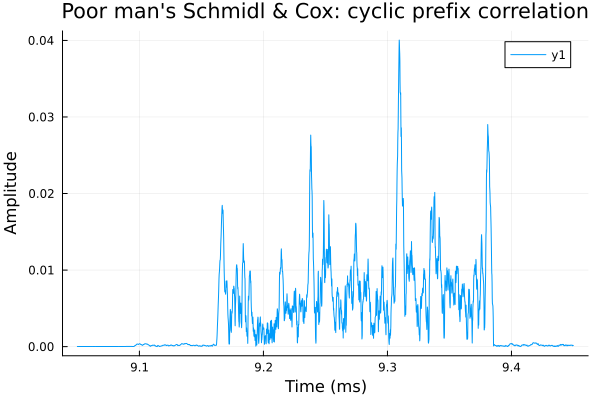

In [84]:
plot(t_corr, abs.(cp_corr)
    , xlabel="Time (ms)"
    , ylabel="Amplitude"
    , title="Poor man's Schmidl & Cox: cyclic prefix correlation"
)

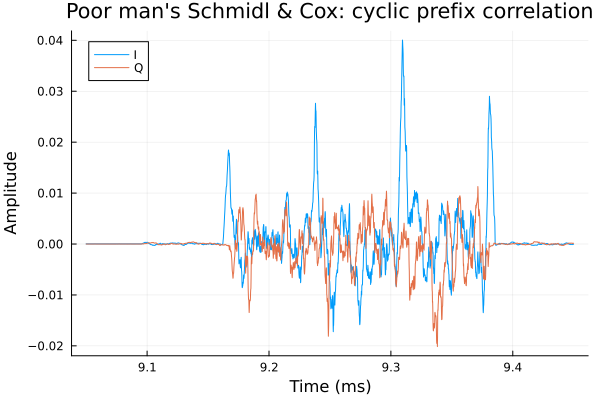

In [85]:
plot(t_corr, real.(cp_corr), label="I")
plot!(t_corr, imag.(cp_corr), label="Q")

xlabel!("Time (ms)")
ylabel!("Amplitude")
title!("Poor man's Schmidl & Cox: cyclic prefix correlation")

In [86]:
m₀ = argmax(abs.(cp_corr[1:1001]))
m₁ = argmax(abs.(cp_corr[1001:1501])) + 1000
m₂ = argmax(abs.(cp_corr[1501:2251])) + 1500
m₃ = argmax(abs.(cp_corr[2251:end])) + 2250;

In [87]:
@show [m₀, m₁, m₂, m₃];
@show cp_corr[[m₀, m₁, m₂, m₃]];
@show (𝑓ₛ / Tu); 

[m₀, m₁, m₂, m₃] = [898, 1446, 1994, 2542]
cp_corr[[m₀, m₁, m₂, m₃]] = ComplexF64[0.018453364171738606 - 0.0003259523120684487im, 0.027630909489268485 + 7.182197607671998e-5im, 0.040046193419243564 - 9.265369157174103e-5im, 0.029007430983299793 - 0.0005109672994236703im]
𝑓ₛ / Tu = 15000.0


In [88]:
CFO_est = -angle.(cp_corr[[m₀, m₁, m₂, m₃]]) / (2 * π) * (𝑓ₛ / Tu); @show CFO_est;

CFO_est = [42.1642853098759, -6.205440021172319, 5.5234713106478015, 42.04848156374781]


In [89]:
-angle.(cp_corr[[m₀, m₁, m₂, m₃]])

4-element Vector{Float64}:
  0.01766173452978269
 -0.0025993286377076065
  0.002313666252246016
  0.017613226770036797

## PSS demodulation

In [90]:
using FFTW

In [91]:
# Start demodulation at the middle of the cyclic prefix for maximum robustness to STO
a₀ = corr_start + m₀ + div(Ncp, 2); @show a₀, corr_start, m₀, div(Ncp,2)


(a₀, corr_start, m₀, div(Ncp, 2)) = (70420, 69504, 898, 18)


(70420, 69504, 898, 18)

In [138]:
Fₓ = fft(x[a₀:a₀+Tu]); @show a₀:a₀+Tu, Fₓ[1];

(a₀:a₀ + Tu, Fₓ[1]) = (70420:70932, -0.8213143720603344 - 0.5675814677022674im)


# &#x1F4A3; Shift betweeen Python &#x1F40D; and Julia &#128131;&#127999;
- [ ] [𝚏𝚏𝚝 vs. 𝚏𝚏𝚝𝚜𝚑𝚒𝚏𝚝 in MATLAB: Please explain](https://dsp.stackexchange.com/questions/40411/tt-fft-vs-tt-fftshift-in-matlab-please-explain)

In [139]:
𝐹ₓ = fftshift(Fₓ); @show 𝐹ₓ[1];

𝐹ₓ[1] = -0.00105112466633628 - 0.0026872818827628035im


In [140]:
# Correct for the 5G NR upconversion discontinuity
# This PSS is transmitted on symbol 2 mod 7
f .*= phase_corr[3]; @show phase_corr[3], f[1];

(phase_corr[3], f[1]) = (-0.8314696123025453 + 0.5555702330196022im, 0.0019994908199740345 + 0.0020804767344157734im)


In [141]:
# Correct for the fact that we're starting the demodulation at the middle of the cyclic prefix
p_t = exp.(1im * 2 * π * fftshift(fftfreq(Tu)) * Ncp / 2); @show p_t[1];

p_t[1] = 1.0 + 2.204364238465236e-15im


In [110]:
# The PSS ocuppies subcarriers 56 to 128 relative to the start of an SS/PBCH block
# In this case, the SS/PBCH block starts at subcarrier -120 (with respect to the
# subcarrier we have decided to treat as DC). This means that the SS/PBCH block is
# not centred with respect to this choice of DC (but this doesn't matter).
pss_sc_sel = range(Int(Tu/2-120+56), Int(Tu/2-120+56+127))

192:319

In [128]:
# x_all_sc = np.arange(f.size) - Tu//2; y_all_sc = 10*np.log10(np.abs(f)**2);
x_all_sc = size(f,1) - div(Tu, 2); y_all_sc = 10 * log10.(abs2.(f));
@show x_all_sc[1]; @show y_all_sc[1];

x_all_sc[1] = 257
y_all_sc[1] = -50.79545494835648


In [129]:
# x_pss_sc = np.arange(f.size)[pss_sc_sel] - Tu//2; y_pss_sc = 10*np.log10(np.abs(f[pss_sc_sel])**2)
x_pss_sc = pss_sc_sel .- div(Tu, 2); y_pss_sc = 10 * log10.(abs2.(f[pss_sc_sel]));
@show x_pss_sc[1]; @show y_pss_sc[1];

x_pss_sc[1] = -64
y_pss_sc[1] = -15.632312394092189


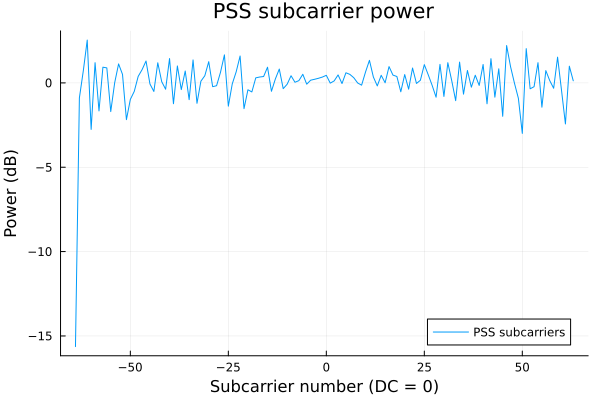

In [126]:
# all_sb_plot = 
# plot(x_all_sc, y_all_sc, label="All subcarriers")
# plot!(x_pss_sc, y_pss_sc, label="PSS subcarriers")
plot(x_pss_sc, y_pss_sc, label="PSS subcarriers")

title!("PSS subcarrier power")
xlabel!("Subcarrier number (DC = 0)")
ylabel!("Power (dB)")

# savefig(all_sb_plot,"images/all_sb_plot.png");

##### <!--img src=images/all_sb_plot.png width='' heigth='' > </img>

In [243]:
pss_sym_demod = f[pss_sc_sel];